# MOS score prediction from wav2vec2 embeddings

* calculate wav2vec2 embeddings for test and train datasets
* create MOSDataset, containing wav2vec2 embeddings and subjective MOS scores
* define a simple neural network to predict MOS scores from wav2vec2 embeddings
* train the neural network and save the model
* evaluate the model
* repeat the process for different wav2vec2 models? other embeddings? use embeddings from different layers? need another 8 months to finish this notebook

In [2]:
import os
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

# wav2vec
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
import librosa

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader



/home/aleph/tesis/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### wav2vec2 embeddings extraction

In [3]:
# define function for extracting embeddings
def wav2vec_embeddings(path_to_csv, model_name):
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
    model = Wav2Vec2Model.from_pretrained(model_name)
    metadata_df = pd.read_csv(path_to_csv)
    # Create a new column to store embeddings
    metadata_df['embeddings'] = None
    # iterate over each path in "stimuli" column
    for index, row in tqdm(metadata_df.iterrows()):
        audio_file = row['stimuli']
        input_audio, sample_rate = librosa.load(audio_file, sr=16000)
        inputs = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
        with torch.no_grad():
            outputs= model(inputs.input_values)
        embeddings = outputs.last_hidden_state
        embeddings = embeddings.mean(dim=1)
        embeddings = embeddings.squeeze().detach().numpy()

        metadata_df.at[index, 'embeddings'] = [embeddings]
                
    return metadata_df


In [19]:
# extract embeddings for train set
path_to_train_csv = '/home/aleph/tesis/classifier/train_set.csv'
model_name = 'facebook/wav2vec2-base-960h'
train_embeddings = wav2vec_embeddings(path_to_train_csv, model_name)
train_embeddings.head()

/home/aleph/tesis/.env/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
3473it [10:15,  5.65it/s]


,db,stimuli,mos,embeddings
0,E2,/home/aleph/tesis/frontend/public/assets/stimu...,5.0,"[[-0.034248985, 0.0075073987, 0.049122877, -0...."
1,E2,/home/aleph/tesis/frontend/public/assets/stimu...,5.0,"[[-0.03282277, 0.004647657, -0.079498954, -0.0..."
2,E2,/home/aleph/tesis/frontend/public/assets/stimu...,5.0,"[[-0.039054234, -0.0037194341, -0.09361432, -0..."
3,E2,/home/aleph/tesis/frontend/public/assets/stimu...,4.0,"[[-0.05925918, 0.013722477, -0.029571388, -0.0..."
4,E2,/home/aleph/tesis/frontend/public/assets/stimu...,4.0,"[[-0.035181016, 0.007110238, -0.008785907, -0...."


In [4]:
# now for the test set
path_to_test_csv = '/home/aleph/tesis/classifier/test_set.csv'
model_name = 'facebook/wav2vec2-base-960h'
test_embeddings = wav2vec_embeddings(path_to_test_csv, model_name)
test_embeddings.head()

/home/aleph/tesis/.env/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]2024-05-04 16:50:41.484379: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebui

In [17]:
train_embeddings.shape, test_embeddings.shape

((3473, 1, 768), (863, 1, 768))

In [5]:
# lets define a function to save the embeddings
def save_embeddings(embeddings_df, path_to_save):
    embeddings_df.to_csv(path_to_save, index=False)
    print(f"Embeddings saved at {path_to_save}")

# save the embeddings
path_to_save_train_embeddings = '/home/aleph/tesis/classifier/train_set_embeddings.csv'
path_to_save_test_embeddings = '/home/aleph/tesis/classifier/test_set_embeddings.csv'
# save_embeddings(train_embeddings, path_to_save_train_embeddings)
save_embeddings(test_embeddings, path_to_save_test_embeddings)

Embeddings saved at /home/aleph/tesis/classifier/test_set_embeddings.csv


### attempt to plot some sort of distribution of the embeddings

In [12]:
# let's explore the embeddings to see distributions of data
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
from numpy import float32

# get the embeddings read from the csv
train_embeddings = pd.read_csv(path_to_save_train_embeddings)
test_embeddings = pd.read_csv(path_to_save_test_embeddings)

# get the embeddings
train_embeddings = train_embeddings['embeddings']
test_embeddings = test_embeddings['embeddings']

# convert the strings to lists
train_embeddings = train_embeddings.apply(lambda x: eval(x))
test_embeddings = test_embeddings.apply(lambda x: eval(x))

# convert the lists to numpy arrays
train_embeddings = np.array(train_embeddings.tolist())
test_embeddings = np.array(test_embeddings.tolist())

# get the shape of the embeddings
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")




Train embeddings shape: (3473, 1, 768)
Test embeddings shape: (863, 1, 768)


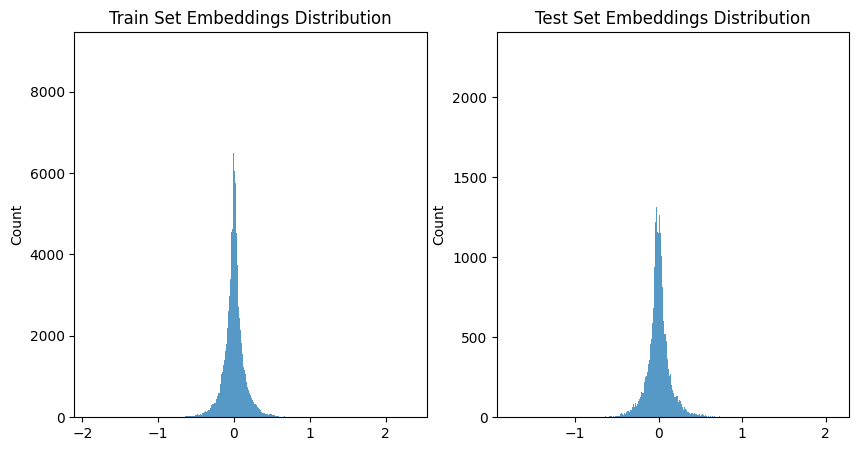

In [23]:
# plot the embeddings
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_embeddings, bins=10000)
plt.title("Train Set Embeddings Distribution")
plt.subplot(1, 2, 2)
sns.histplot(test_embeddings, bins=10000)
plt.title("Test Set Embeddings Distribution")
plt.show()

In [37]:
#drop the first dimension
train_embeddings_squeeze = train_embeddings.squeeze()
train_embeddings_squeeze.shape

(3473, 768)

In [38]:
import umap.umap_ as umap

#Create a numpy array with the features and project them to 2D using UMAP:
X = np.stack(train_embeddings_squeeze)
print('Projecting to 2D with UMAP')
projector = umap.UMAP()
projected = projector.fit_transform(X)
metadata_df = pd.DataFrame()
metadata_df['X'] = projected[:,0]
metadata_df['Y'] = projected[:,1]

Projecting to 2D with UMAP


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


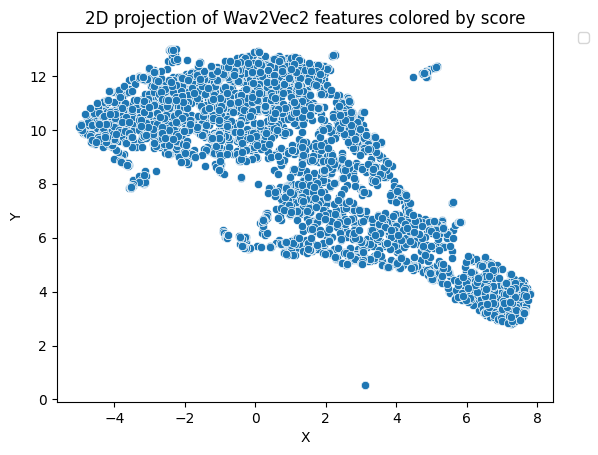

In [40]:
plt.title('2D projection of Wav2Vec2 features colored by score')
sns.scatterplot(data=metadata_df,x='X',y='Y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Projecting to 2D with UMAP


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


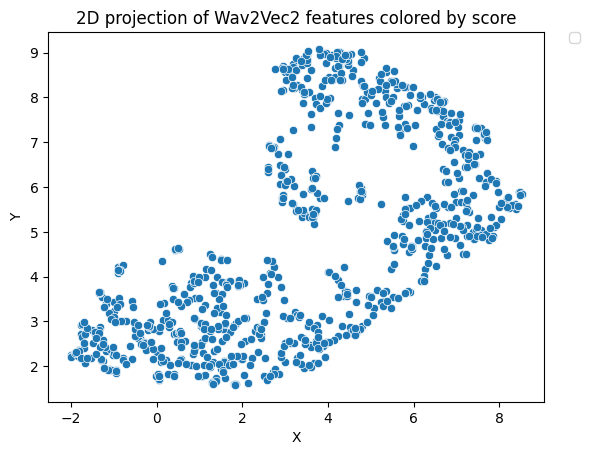

In [41]:
import umap.umap_ as umap

#Create a numpy array with the features and project them to 2D using UMAP:
X = np.stack(test_embeddings.squeeze())
print('Projecting to 2D with UMAP')
projector = umap.UMAP()
projected = projector.fit_transform(X)
metadata_df = pd.DataFrame()
metadata_df['X'] = projected[:,0]
metadata_df['Y'] = projected[:,1]

plt.title('2D projection of Wav2Vec2 features colored by score')
sns.scatterplot(data=metadata_df,x='X',y='Y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# MOSDataset
* Convert the embeddings from string representations into proper tensors.
* Separate the data into features (embeddings) and targets (MOS scores).

In [45]:
# Custom dataset to read embeddings and MOS scores from a CSV
from numpy import array
from numpy import float32

class MOSDataset(Dataset):
    def __init__(self, csv_file):
        # Load the CSV file
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.data)  # Total number of samples in the dataset
    
    def __getitem__(self, idx):
        # Get the embeddings and MOS scores for the given index
        embeddings_str = self.data.iloc[idx]['embeddings']
        mos_score = self.data.iloc[idx]['mos']

        # Convert the string of embeddings to a tensor
        embeddings = np.array(eval(embeddings_str))  # Convert from string to numpy array
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)  # Convert to PyTorch tensor
        
        # Average the embeddings over the sequence dimension (assuming they are 2D arrays)
        feature_vector = embeddings_tensor.mean(dim=0)  # Average over the time axis
        
        # MOS score should be a single value
        mos_tensor = torch.tensor([mos_score], dtype=torch.float32)  # Convert to tensor
        
        return feature_vector, mos_tensor

# Create the training DataLoader
train_csv_path = "train_set_embeddings.csv"  # Adjust the path to your CSV file
train_dataset = MOSDataset(train_csv_path)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)  # DataLoader with batching and shuffling

# Create the testing DataLoader
test_csv_path = "test_set_embeddings.csv"  # Adjust the path to your CSV file
test_dataset = MOSDataset(test_csv_path)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2) 

In [46]:
# Test the DataLoader by iterating over a few batches
for i, (features, targets) in enumerate(test_loader):
    print(f"Batch {i + 1}")
    print("Feature Shape:", features.shape)  # Should be (batch_size, 768)
    print("Target Shape:", targets.shape)  # Should be (batch_size, 1)
    print("First Few Feature Vectors:", features[:5])  # Display a few sample feature vectors
    print("First Few MOS Scores:", targets[:5])  # Display a few sample MOS scores
    
    # Limit to a few batches for testing
    if i >= 2:  # Test the first 3 batches
        break


Batch 1
Feature Shape: torch.Size([32, 768])
Target Shape: torch.Size([32, 1])
First Few Feature Vectors: tensor([[-0.0447,  0.0072, -0.0044,  ..., -0.1055, -0.0296, -0.1492],
        [-0.0370, -0.0232, -0.0397,  ..., -0.1030, -0.0137, -0.0771],
        [-0.0547,  0.0087,  0.0268,  ..., -0.0783, -0.0033, -0.1348],
        [-0.0730, -0.0006,  0.0096,  ..., -0.0795, -0.0194, -0.1615],
        [-0.1043,  0.0220, -0.0800,  ..., -0.0773,  0.0119, -0.0217]])
First Few MOS Scores: tensor([[2.],
        [3.],
        [1.],
        [2.],
        [2.]])
Batch 2
Feature Shape: torch.Size([32, 768])
Target Shape: torch.Size([32, 1])
First Few Feature Vectors: tensor([[-0.0547,  0.0220, -0.0394,  ..., -0.1342, -0.0058, -0.0791],
        [-0.0572, -0.0004,  0.0525,  ..., -0.1182, -0.0211, -0.1296],
        [-0.0632,  0.0113,  0.0747,  ..., -0.0708, -0.0296, -0.1467],
        [-0.0726,  0.0292, -0.0175,  ..., -0.1122, -0.0108, -0.1174],
        [-0.0651,  0.0228,  0.0147,  ..., -0.0817, -0.0225, -0.0

# Neural network

In [43]:
# Define the DenseMOS model for a single 768-dimensional input
batch_size = 32  # Batch size for training
class DenseMOS(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob):
        super(DenseMOS, self).__init__()
        
        # First dense layer with 128 neurons, ReLU activation, and dropout
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Linear layer for dense transformation
            nn.ReLU(),  # ReLU activation
            nn.Dropout(dropout_prob),  # Dropout with 0.2
        )

        # Second dense layer with 128 neurons, ReLU activation, and dropout
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),  # Another dense transformation
            nn.ReLU(),
            nn.Dropout(dropout_prob),
        )

        # Final dense layer for MOS score prediction
        self.output_layer = nn.Linear(hidden_dim, 1)  # Linear layer to predict MOS

    def forward(self, x):
        # Pass the input through the first dense layer
        x = self.layer1(x)

        # Pass through the second dense layer
        x = self.layer2(x)

        # Pass through the final dense layer to get the MOS score
        x = self.output_layer(x)  # Output layer

        # Constrain the output to the 1-5 range
        x = torch.sigmoid(x)  # Constrain between 0 and 1
        x = 1 + 4 * x  # Scale to 1-5

        return x


# Define the model parameters
input_dim = 768  # Single 768-dimensional input
hidden_dim = 128  # Hidden dimension for dense layers
dropout_prob = 0.2  # Dropout probability

# Instantiate the DenseMOS model
dense_mos = DenseMOS(input_dim, hidden_dim, dropout_prob)

# Create a dummy input tensor with a batch of 32 samples, each 768-dimensional
# batch_size = 32  # Batch size
# input_tensor = torch.randn(batch_size, input_dim)  # Random input for testing

# # Pass the input tensor through the model
# output_tensor = dense_mos(input_tensor)

# # Check the shape of the output tensor
# print(output_tensor.shape)  # Should be (32, 1), indicating batch_size x MOS score

# # Output the values to confirm they are within the expected range
# print("Output values:", output_tensor)


## Define a Loss Function and Optimizer


In [50]:
# define loss and optimizer
loss_fn = nn.MSELoss()  # Mean squared error loss
optimizer = optim.Adam(dense_mos.parameters(), lr=1e-5)  # Adam optimizer with learning rate 1e-3

## Training Loop

In [52]:
import torch
from tqdm import tqdm  # For progress bar
from torch.utils.data import DataLoader

# Number of epochs and batch size
num_epochs = 10 # Number of training epochs
batch_size = 32  # Batch size for training

# DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Ensure batch size and shuffle
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for validation

# Track training and validation loss
train_losses = []
val_losses = []

# For early stopping
best_val_loss = float('inf')  # To track the best validation loss

for epoch in range(num_epochs):
    # Training phase with progress bar
    dense_mos.train()  # Set model to training mode
    train_loss = 0.0  # Initialize the training loss
    
    # Use tqdm for progress tracking
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Zero out the gradients
            
            outputs = dense_mos(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Compute the loss
            loss.backward()  # Backpropagation
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(dense_mos.parameters(), 1.0)  # Adjust value if needed
            
            optimizer.step()  # Update the weights
            
            train_loss += loss.item()  # Accumulate the loss
            
            pbar.update(1)  # Update the progress bar

    train_loss /= len(train_loader)  # Average loss over all batches
    train_losses.append(train_loss)  # Save the training loss

    # Validation phase
    dense_mos.eval()  # Set model to evaluation mode
    val_loss = 0.0  # Initialize the validation loss

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = dense_mos(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Calculate loss
            val_loss += loss.item()  # Accumulate the validation loss

    val_loss /= len(val_loader)  # Average validation loss over all batches
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the model (optional)
        torch.save(dense_mos.state_dict(), "best_model.pth")


Epoch 1/10: 100%|██████████| 109/109 [00:06<00:00, 17.45it/s]


Epoch 1/10, Training Loss: 1.1095, Validation Loss: 1.4201


Epoch 2/10: 100%|██████████| 109/109 [00:04<00:00, 24.03it/s]


Epoch 2/10, Training Loss: 1.0998, Validation Loss: 1.4195


Epoch 3/10: 100%|██████████| 109/109 [00:03<00:00, 27.30it/s]


Epoch 3/10, Training Loss: 1.1209, Validation Loss: 1.4204


Epoch 4/10: 100%|██████████| 109/109 [00:06<00:00, 17.52it/s]


Epoch 4/10, Training Loss: 1.1114, Validation Loss: 1.4212


Epoch 5/10: 100%|██████████| 109/109 [00:04<00:00, 24.72it/s]


Epoch 5/10, Training Loss: 1.1022, Validation Loss: 1.4212


Epoch 6/10: 100%|██████████| 109/109 [00:03<00:00, 27.79it/s]


Epoch 6/10, Training Loss: 1.1030, Validation Loss: 1.4209


Epoch 7/10: 100%|██████████| 109/109 [00:04<00:00, 26.23it/s]


Epoch 7/10, Training Loss: 1.1177, Validation Loss: 1.4221


Epoch 8/10: 100%|██████████| 109/109 [00:03<00:00, 29.34it/s]


Epoch 8/10, Training Loss: 1.1056, Validation Loss: 1.4202


Epoch 9/10: 100%|██████████| 109/109 [00:03<00:00, 28.15it/s]


Epoch 9/10, Training Loss: 1.1091, Validation Loss: 1.4226


Epoch 10/10: 100%|██████████| 109/109 [00:03<00:00, 29.51it/s]


Epoch 10/10, Training Loss: 1.1145, Validation Loss: 1.4234


## Evaluation and Testing

In [54]:
# Load the best model
best_model_path = "/home/aleph/tesis/classifier/best_model.pth"
dense_mos = DenseMOS(input_dim=768, hidden_dim=128, dropout_prob=0.2)  # Ensure correct model initialization
dense_mos.load_state_dict(torch.load(best_model_path))  # Load the saved model
dense_mos.eval()  # Set model to evaluation mode

# Evaluate the model on the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # DataLoader for testing
test_loss = 0.0
with torch.no_grad():  # No gradients needed during evaluation
    for inputs, targets in test_loader:
        outputs = dense_mos(inputs)  # Forward pass
        loss = loss_fn(outputs, targets)  # Calculate loss
        test_loss += loss.item()  # Accumulate the loss

# Average test loss over all batches
avg_test_loss = test_loss / len(test_loader)
print("Test Loss:", avg_test_loss)  # Evaluate the model's performance on the test set


Test Loss: 1.4195223538963884


### sanity check and experiments

In [96]:
# Load the trained model
best_model_path = "/home/aleph/tesis/classifier/best_model.pth"
dense_mos = DenseMOS(input_dim=768, hidden_dim=128, dropout_prob=0.2)  # Ensure model initialization
dense_mos.load_state_dict(torch.load(best_model_path))  # Load the saved model
dense_mos.eval()  # Set model to evaluation mode

def wav2vec_single_audio(path_to_audio, model_name):
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
    model = Wav2Vec2Model.from_pretrained(model_name)
    waveform, sample_rate = librosa.load(path_to_audio, sr=16000)
    inputs = feature_extractor(waveform, return_tensors="pt")
    with torch.no_grad():
        outputs= model(inputs.input_values)
    embeddings = outputs.last_hidden_state
    embeddings = embeddings.mean(dim=1)
    embeddings = embeddings.squeeze().detach().numpy()
                
    return embeddings

# Path to the new audio file
new_audio_path = "/home/aleph/tesis/frontend/public/assets/stimuli_norm/A/A1/0.wav"
new_audio_path = "/home/aleph/tesis/classifier/sanity_check/chirp.wav"
# Extract embeddings for the new audio
new_audio_embeddings = wav2vec_single_audio(new_audio_path, model_name)

# Convert to PyTorch tensor
new_audio_tensor = torch.tensor(new_audio_embeddings, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Make a prediction using the model
with torch.no_grad():  # No gradients required for inference
    mos_score = dense_mos(new_audio_tensor)  # Forward pass to get the MOS score

# Output the MOS score
print("Predicted MOS Score:", mos_score.item())  # Get the scalar value from the tensor


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Predicted MOS Score: 1.737671971321106
